In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)


In [2]:

# Try importing optional external libraries
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except ImportError:
    HAS_CAT = False



In [3]:
# --- Data loading ---
DATA_DIR = "../preprocessed_tabular_data"

train = pd.read_csv(os.path.join(DATA_DIR, "train_prepared.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test_prepared.csv"))

# Separate features/labels
X = train.drop(columns=["label", "tic_id", "obj_id", "object_name", "star_name"], errors="ignore")
y = train["label"]

# Keep only numeric features
X = X.select_dtypes(include=[np.number])

print("Training shape:", X.shape)
print("Features used:", X.columns.tolist())



Training shape: (12445, 6)
Features used: ['period', 'duration', 'depth', 'stellar_radius', 'stellar_mass', 'stellar_mag']


In [4]:
# --- Define models ---
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=5,
        random_state=42, use_label_encoder=False, eval_metric="logloss"
    )

if HAS_LGBM:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=300, learning_rate=0.1, random_state=42
    )

if HAS_CAT:
    models["CatBoost"] = CatBoostClassifier(
        n_estimators=300, learning_rate=0.1, random_state=42, verbose=0
    )


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []

for name, model in models.items():
    print(f"Training {name}...")
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    result_summary = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
    result_summary['model'] = name
    results.append(result_summary)

# Collect results
results_df = pd.DataFrame(results)
print(results_df)

Training RandomForest...
Training ExtraTrees...
Training AdaBoost...


C:\Users\Md Sahanawaj Karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Md Sahanawaj Karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Md Sahanawaj Karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Md Sahanawaj Karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: Fu

Training GradientBoosting...
   accuracy  precision    recall        f1   roc_auc             model
0  0.815910   0.825571  0.894602  0.858673  0.881995      RandomForest
1  0.811651   0.817485  0.899614  0.856570  0.875177        ExtraTrees
2  0.775412   0.770072  0.913496  0.835655  0.820589          AdaBoost
3  0.804419   0.805264  0.906427  0.852836  0.870206  GradientBoosting


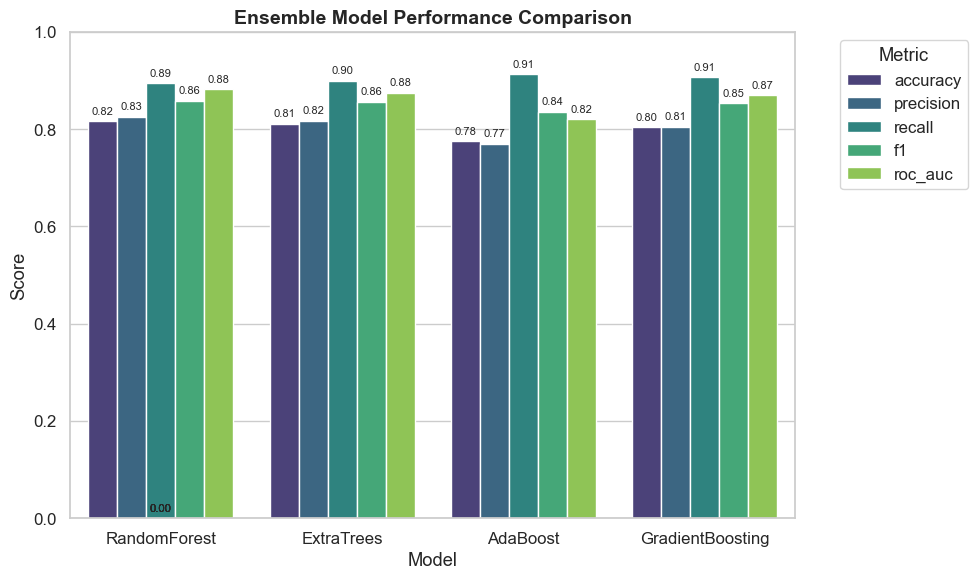

✅ Plot saved to ../plots_of_experiment_on_tabular_dataset/ensemble_results_plot.png


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#

# Melt the dataframe for easier plotting
results_melted = results_df.melt(id_vars="model", var_name="metric", value_name="score")

# Set the style
sns.set(style="whitegrid", font_scale=1.1)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_melted,
    x="model",
    y="score",
    hue="metric",
    palette="viridis"
)

# Add titles and labels
plt.title("Ensemble Model Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate scores on top of bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Adjust layout
plt.tight_layout()

# Save the figure
save_path = "../plots_of_experiment_on_tabular_dataset/ensemble_results_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to {save_path}")


In [10]:
# Save results
os.makedirs("../metrics", exist_ok=True)
results_df.to_csv("../metrics/ensemble_results.csv", index=False)